<a href="https://colab.research.google.com/github/igornunespatricio/spark-project-customer-churn/blob/main/spark_xgboost_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up environment


1.   Install Java
2.   Install and unpack Spark and Hadoop Distributed File System (HDFS)
3.   Define environment variables for Java and Spark
4.   Install and initialize findspark
5.   Check Spark installation



In [1]:
# Java installation
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
# Downloading Spark and Hadoop Distributed File System (HDFS) files
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz

# Unpacking files
!tar xf spark-3.1.2-bin-hadoop2.7.tgz

In [3]:
# Importing os library
import os

# Defining Java's system variable
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# Defining Spark's system variable
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [4]:
# Necessary to run PySpark
!pip install -q findspark

In [5]:
# Importing installed finspark library
import findspark

# Initialize findspark
findspark.init()

In [6]:
# # Importing package to initialize Spark session
from pyspark.sql import SparkSession

# # Imprting package to get number of cpu workers
# import multiprocessing

# cores = multiprocessing.cpu_count() # Count the number of cores in the computer
# print(f"Computer has {cores} cores")

# # Initialize spark session
# sc = SparkSession.builder.master('local[*]').getOrCreate()

# # Check if session was created
# sc

If everything is right, the output of the last cell should per below:

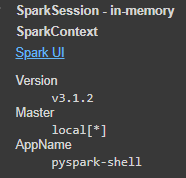

# Downloading Kaggle Dataset

In this case, a customer-churn dataset found [here](https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset) will be used. More info on the dataset in this link.

1. Install Kaggle package
2. Upload kaggle.json file with credentials (follow instructions [here](https://www.kaggle.com/discussions/general/74235))
3. Create kaggle directory
4. Upload kaggle.json file
5. Change permition of kaggle json file
6. Copy API command from the Kaggle dataset you want to use by clicking in $\ \vdots$  
 and then "Copy API Command". In this case, [this](https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset) dataset is being used
7. Paste the copied command above in a new code cell and run
8. After waiting the download to finish, under the /content diretory you should have the zipped file with the dataset in the /content directory
9. Unzip the data into a directory of choice. In this case, "customer-churn"

In [7]:
# Importing Kaggle package
!pip install -q kaggle

In [8]:
# Upload your Kaggles API secret KEY in file kaggle.json (link: https://www.kaggle.com/discussions/general/74235)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"igornunespatricio","key":"7f5d35c1c5bd7334abed0a8e12172c4c"}'}

In [9]:
# Create kaggle directory
!mkdir ~/.kaggle

In [10]:
# Copy kaggle json file to the created directory
! cp kaggle.json ~/.kaggle/

In [11]:
# Change permission of the file
!chmod 600 ~/.kaggle/kaggle.json

In [12]:
# Check if everything is correct
!kaggle datasets list

ref                                                         title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/countries-of-the-world-2023                Global Country Information Dataset 2023           23KB  2023-07-08 20:37:33          10301        398  1.0              
juhibhojani/house-price                                     House Price                                        7MB  2023-08-02 16:51:21           1415         51  0.9411765        
arnavsmayan/netflix-userbase-dataset                        Netflix Userbase Dataset                          25KB  2023-07-04 07:38:41          11854        206  1.0              
alphiree/cardiovascular-diseases-risk-prediction-dataset    Cardiovascular Diseases Risk Predic

In [13]:
# Downloading the Dataset from Kaggle
!kaggle datasets download -d muhammadshahidazeem/customer-churn-dataset

 75% 5.00M/6.66M [00:00<00:00, 43.9MB/s]
100% 6.66M/6.66M [00:00<00:00, 50.9MB/s]


In [14]:
# Unzipping content to another folder
!unzip /content/customer-churn-dataset.zip -d customer-churn

Archive:  /content/customer-churn-dataset.zip
  inflating: customer-churn/customer_churn_dataset-testing-master.csv  
  inflating: customer-churn/customer_churn_dataset-training-master.csv  


# Machine Learning

In [15]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

pyspark_config = [
    ('spark.app.name','Customer-Churn'),
    ('spark.executor.memory','4g'),
    ('spark.master','local[*]'),
    ('spark.driver.memory','4g'),
    ('spark.driver.cores','2')
]

conf = SparkConf().setAll(pyspark_config)

sp = SparkSession.builder.config(conf=conf).getOrCreate()

# print(sp.sparkContext.getConf().get("spark.master"))
# print(sp.sparkContext.getConf().get("spark.executor.memory"))

for configuration in pyspark_config:
    config_value = sp.sparkContext.getConf().get(configuration[0])
    print(f"{configuration[0]}: {config_value}")

spark.app.name: Customer-Churn
spark.executor.memory: 4g
spark.master: local[*]
spark.driver.memory: 4g
spark.driver.cores: 2


In [16]:
FILEPATH = "/content/customer-churn/customer_churn_dataset-training-master.csv"
# Read csv file (if another file  type, search PySpark documentation)
df = sp.read.options(header=True, inferSchema=True).csv(FILEPATH)
df.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Usage Frequency: integer (nullable = true)
 |-- Support Calls: integer (nullable = true)
 |-- Payment Delay: integer (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Contract Length: string (nullable = true)
 |-- Total Spend: double (nullable = true)
 |-- Last Interaction: integer (nullable = true)
 |-- Churn: integer (nullable = true)



In [17]:
# train and test split
seed = 42
df_train, df_test = df.randomSplit(weights=[0.7, 0.3], seed=seed)

In [18]:
num_churns = df_test.rdd.map(lambda x: x["Churn"]==1).sum()
total = df_test.count()
print(f'Churns: {num_churns}\nTotal observations: {total}\nProportion of Churns: {num_churns/total:.4%}')

Churns: 75143
Total observations: 132195
Proportion of Churns: 56.8425%


In [19]:
from pyspark.sql.functions import count, when, isnull
# Checking Null values
df.agg(*[count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|         1|  1|     1|     1|              1|            1|            1|                1|              1|          1|               1|    1|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+



In [21]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from xgboost.spark import SparkXGBClassifier

# Use int and double types columns as features for random forest model
feature_col = [col_name for col_name, col_type in df.dtypes if (col_type in ('int', 'double') and (col_name not in ('Churn', 'CustomerID')))]
assembler = VectorAssembler(inputCols=feature_col, outputCol='features', handleInvalid='skip')
classifier = SparkXGBClassifier(features_col="features", label_col="Churn", num_workers=2)
pipeline = Pipeline(stages=[assembler, classifier])
model = pipeline.fit(df_train)
predictions = model.transform(df_test).select("Churn", "prediction", "probability")

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


In [24]:
predictions.groupby("Churn", "prediction").count().show()

+-----+----------+-----+
|Churn|prediction|count|
+-----+----------+-----+
|    1|       0.0| 3491|
|    0|       0.0|57042|
|    1|       1.0|71652|
|    0|       1.0|   10|
+-----+----------+-----+



In [25]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.dataframe import DataFrame

binary_evaluator = BinaryClassificationEvaluator(labelCol="Churn", rawPredictionCol="prediction")
multi_evaluator = MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction", probabilityCol='probability')
binary_metric_names = ['areaUnderROC', 'areaUnderPR']
multiclass_metric_names = "f1|accuracy|weightedPrecision|weightedRecall|weightedTruePositiveRate| weightedFalsePositiveRate|weightedFMeasure|truePositiveRateByLabel| falsePositiveRateByLabel|precisionByLabel|recallByLabel|fMeasureByLabel| logLoss|hammingLoss"
multiclass_metric_names = [item.strip() for item in multiclass_metric_names.split('|')]

def printMetrics(
    pred: DataFrame = None,
    binaryEvaluator: BinaryClassificationEvaluator = None,
    binaryMetrics: list[str] = None,
    multiclassEvaluator: MulticlassClassificationEvaluator = None,
    multiclassMetrics: list[str] = None
    ) -> dict:
    """
    Print Binary and Multiclass metrics.
    """
    metrics = dict()
    multiclass_metrics = dict()
    if pred and binaryEvaluator and binaryMetrics:
        binary_metrics = dict()
        print("Binary Metrics")
        for item in binaryMetrics:
            binary_metric = binaryEvaluator.evaluate(
                dataset=pred,
                params={
                    binaryEvaluator.metricName: item
                    }
            )
            binary_metrics[item] = binary_metric
            print(f'{item}: {binary_metric:.2%}')
        print('\n')
    if pred and multiclassEvaluator and multiclassMetrics:
        print("\nMulticlass Metrics")
        for item in multiclass_metric_names:
            multi_metric = multi_evaluator.evaluate(
                dataset=pred,
                params={
                    multi_evaluator.metricName: item
                }
            )
            multiclass_metrics[item] = multi_metric
            print(f'{item}: {multi_metric:.2%}')
    metrics["Binary"] = binary_metrics
    metrics["Multiclass"] = multiclass_metrics
    return metrics

printMetrics(
    pred=predictions,
    binaryEvaluator = binary_evaluator,
    binaryMetrics=binary_metric_names,
    multiclassEvaluator=multi_evaluator,
    multiclassMetrics=multiclass_metric_names
)

Binary Metrics
areaUnderROC: 97.67%
areaUnderPR: 98.98%



Multiclass Metrics
f1: 97.36%
accuracy: 97.35%
weightedPrecision: 97.50%
weightedRecall: 97.35%
weightedTruePositiveRate: 97.35%
weightedFalsePositiveRate: 2.01%
weightedFMeasure: 97.36%
truePositiveRateByLabel: 99.98%
falsePositiveRateByLabel: 4.65%
precisionByLabel: 94.23%
recallByLabel: 99.98%
fMeasureByLabel: 97.02%
logLoss: 9.65%
hammingLoss: 2.65%


{'Binary': {'areaUnderROC': 0.9766833173626468,
  'areaUnderPR': 0.9898386331822903},
 'Multiclass': {'f1': 0.9735944220902826,
  'accuracy': 0.9735163962328378,
  'weightedPrecision': 0.9750313330797289,
  'weightedRecall': 0.9735163962328378,
  'weightedTruePositiveRate': 0.9735163962328378,
  'weightedFalsePositiveRate': 0.020149761507544363,
  'weightedFMeasure': 0.9735944220902826,
  'truePositiveRateByLabel': 0.9998247213068779,
  'falsePositiveRateByLabel': 0.04645808658158444,
  'precisionByLabel': 0.9423289775824757,
  'recallByLabel': 0.9998247213068779,
  'fMeasureByLabel': 0.9702257941063911,
  'logLoss': 0.0965195212809479,
  'hammingLoss': 0.026483603767162148}}

In [26]:
model.write().overwrite().save("xgboost_model")

In [27]:
from pyspark.ml import PipelineModel
model_loaded = PipelineModel.load(r'xgboost_model')
predictions_loaded_model = model_loaded.transform(df_test)

metrics = printMetrics(
    pred=predictions_loaded_model,
    binaryEvaluator = binary_evaluator,
    binaryMetrics=binary_metric_names,
    multiclassEvaluator=multi_evaluator,
    multiclassMetrics=multiclass_metric_names
)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


Binary Metrics
areaUnderROC: 97.67%
areaUnderPR: 98.98%



Multiclass Metrics
f1: 97.36%
accuracy: 97.35%
weightedPrecision: 97.50%
weightedRecall: 97.35%
weightedTruePositiveRate: 97.35%
weightedFalsePositiveRate: 2.01%
weightedFMeasure: 97.36%
truePositiveRateByLabel: 99.98%
falsePositiveRateByLabel: 4.65%
precisionByLabel: 94.23%
recallByLabel: 99.98%
fMeasureByLabel: 97.02%
logLoss: 9.65%
hammingLoss: 2.65%


In [29]:
from google.colab import files

!zip -r xgboost_model.zip xgboost_model/
files.download('xgboost_model.zip')

  adding: xgboost_model/ (stored 0%)
  adding: xgboost_model/metadata/ (stored 0%)
  adding: xgboost_model/metadata/part-00000 (deflated 24%)
  adding: xgboost_model/metadata/._SUCCESS.crc (stored 0%)
  adding: xgboost_model/metadata/_SUCCESS (stored 0%)
  adding: xgboost_model/metadata/.part-00000.crc (stored 0%)
  adding: xgboost_model/stages/ (stored 0%)
  adding: xgboost_model/stages/0_VectorAssembler_7f38a8a481e0/ (stored 0%)
  adding: xgboost_model/stages/0_VectorAssembler_7f38a8a481e0/metadata/ (stored 0%)
  adding: xgboost_model/stages/0_VectorAssembler_7f38a8a481e0/metadata/part-00000 (deflated 37%)
  adding: xgboost_model/stages/0_VectorAssembler_7f38a8a481e0/metadata/._SUCCESS.crc (stored 0%)
  adding: xgboost_model/stages/0_VectorAssembler_7f38a8a481e0/metadata/_SUCCESS (stored 0%)
  adding: xgboost_model/stages/0_VectorAssembler_7f38a8a481e0/metadata/.part-00000.crc (stored 0%)
  adding: xgboost_model/stages/1_SparkXGBClassifier_db4786765e0c/ (stored 0%)
  adding: xgboost_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# TODO

1. Need to check how to save and load transformers with parameters passed by user in pyspark

2. apply categorical features also from the link on step 2 above